# Multifidelity Modelling with Autoregressive Model

This tutorial demonstrates the usage of the `MultifidelityAutoregressive` model for fitting multifidelity data. This is an implementation of the AR1 model initially described in :cite:`Kennedy2000`. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1793)
tf.random.set_seed(1793)

2022-12-02 14:38:06.109806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 14:38:06.109832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Describe the problem

In this tutorial we will consider the scenario where we have a simulator that can be run at three fidelities, with the ability to get cheap but coarse results at the lowest fidelity, more expensive but more refined results at a middle fidelity and very accurate but very expensive results at the highest fidelity. 

We define the true functions for the fidelities as:

$$ f_{i} : [0, 1] \rightarrow \reals $$

$$ f_0(x) = \frac{\sin(12x -4)(6x - 2)^2 + 10(x-1)}{2}, \quad x \in [0,1] $$


$$ f_i(x) =  f_{i-1}(x) + i(f_{i-1}(x) - 20(x - 1)), \quad  x \in [0,1] , \quad  i \in \mathbb{N} $$   

Note that noise is optionally added to any observations in all but the lowest fidelity. There are a few modelling assumptions:
1. The lowest fidelity is noise-free
2. The data is cascading, e.g any point that has an observation at a high fidelity also has one at the lower fidelities. 

2022-12-02 14:38:07.717617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 14:38:07.717641: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 14:38:07.717658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (goodalla-lptp): /proc/driver/nvidia/version does not exist
2022-12-02 14:38:07.717877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


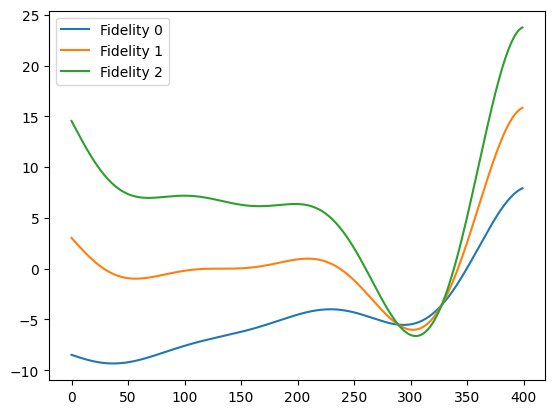

In [2]:
# Define the multifidelity simulator
def simulator(x_input, fidelity, add_noise=False):

    f = 0.5 * ((6.0 * x_input - 2.0) ** 2) * tf.math.sin(12.0 * x_input - 4.0) + 10.0 * (
        x_input - 1.0
    )
    f = f + fidelity * (f - 20.0 * (x_input - 1.0))
    if add_noise:
        noise = tf.random.normal(f.shape, stddev=1e-1, dtype=f.dtype)
    else:
        noise = 0
    f = tf.where(fidelity > 0, f + noise, f)
    return f

# Plot the fidelities
xs = np.linspace(0, 1, 400)

y0 = simulator(xs, 0)
y1 = simulator(xs, 1)
y2 = simulator(xs, 2)

plt.plot(y0, label="Fidelity 0")
plt.plot(y1, label="Fidelity 1")
plt.plot(y2, label="Fidelity 2")
plt.legend()
plt.show()


Trieste handles fidelities by adding an extra column to the data containing the fidelity information of the query point. The function `check_and_extract_fidelity_query_points` will check that the fidelity column is valid, and if so, will separate the query points and the fidelity information.

In [3]:
from trieste.data import Dataset, check_and_extract_fidelity_query_points
# Create an observer class to deal with multifidelity input query points
class Observer:
    def __init__(self):

        self.simulator = simulator

    def __call__(self, x, add_noise=True):

        # Extract raw input and fidelity columns
        x_input, x_fidelity = check_and_extract_fidelity_query_points(x)

        # note: this assumes that my_simulator broadcasts, i.e. accept matrix inputs.
        # If not you need to replace this by a for loop over all rows of "input"
        observations = self.simulator(x_input, x_fidelity, add_noise)
        return Dataset(query_points=x, observations=observations)

# Instantiate the observer
observer = Observer()

/home/alexander.goodall/.pyenv/versions/3.7.13/envs/multifidelity/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/home/alexander.goodall/.pyenv/versions/3.7.13/envs/multifidelity/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."


Now we can define the other parameters of our problem, such as the input dimension, search space and number of fidelities.

In [4]:
from trieste.space import Box

input_dim = 1

lb = np.zeros(input_dim)
ub = np.ones(input_dim)

n_fidelities = 3

input_search_space = Box(lb, ub)


## Create initial dataset

In [5]:
# Define sample sizes of low, mid and high fidelities
sample_sizes = [18, 12, 6] 

xs = [tf.linspace(0, 1, sample_sizes[0])[:, None]]

# Take a subsample of each lower fidelity to sample at the next fidelity up
for fidelity in range(1, n_fidelities):
    samples = tf.Variable(np.random.choice(xs[fidelity - 1][:, 0], size=sample_sizes[fidelity], replace=False))[
        :, None
    ]
    xs.append(samples)

initial_samples_list = [tf.concat([x, tf.ones_like(x) * i], 1) for i, x in enumerate(xs)]
initial_sample = tf.concat(initial_samples_list, 0)
initial_data = observer(initial_sample, add_noise=True)

We can plot the initial data. We separate the dataset into individual fidelities using the `split_dataset_by_fidelity` function.

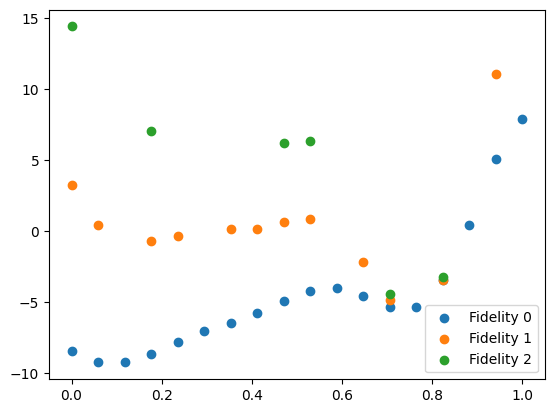

In [6]:
from trieste.data import split_dataset_by_fidelity

data = split_dataset_by_fidelity(initial_data, num_fidelities=n_fidelities)

plt.scatter(data[0].query_points, data[0].observations, label="Fidelity 0")
plt.scatter(data[1].query_points, data[1].observations, label="Fidelity 1")
plt.scatter(data[2].query_points, data[2].observations, label="Fidelity 2")
plt.legend()
plt.show()

Now we can fit the `MultifidelityAutoregressive` model to this data. We use the `build_multifidelity_autoregressive_models` to create the sub-models required by the multifidelity model.

In [7]:
from trieste.models.gpflow import MultifidelityAutoregressive, build_multifidelity_autoregressive_models

# Initialise model
multifidelity_model = MultifidelityAutoregressive(build_multifidelity_autoregressive_models(initial_data, n_fidelities, input_search_space))

# Update and optimize model
multifidelity_model.update(initial_data)
multifidelity_model.optimize(initial_data)

/home/alexander.goodall/.pyenv/versions/3.7.13/envs/multifidelity/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
2022-12-02 14:38:10.170911: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-02 14:38:12.432113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-02 14:38:12.462701: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


## Plot Results

Now we can plot the results to have a look at the fit.

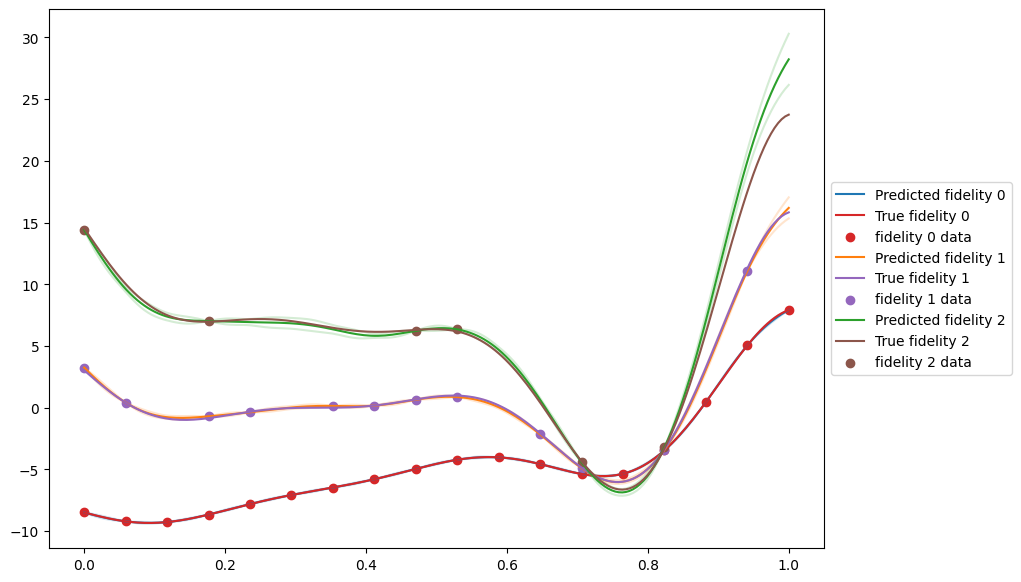

In [8]:
X = tf.linspace(0, 1, 200)[:, None]
X_list = [tf.concat([X, tf.ones_like(X) * i], 1) for i in range(n_fidelities)]
predictions = [multifidelity_model.predict(x) for x in X_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

pred_colors = ['tab:blue', 'tab:orange', 'tab:green']
gt_colors = ['tab:red', 'tab:purple', 'tab:brown']

for fidelity, prediction in enumerate(predictions):
    mean, var = prediction
    ax.plot(X, mean, label=f"Predicted fidelity {fidelity}", color=pred_colors[fidelity])
    ax.plot(X, mean + 1.96 * tf.math.sqrt(var), alpha=0.2, color=pred_colors[fidelity])
    ax.plot(X, mean - 1.96 * tf.math.sqrt(var), alpha=0.2, color=pred_colors[fidelity])
    ax.plot(
        X,
        observer(X_list[fidelity], add_noise=False).observations,
        label=f"True fidelity {fidelity}",
        color=gt_colors[fidelity]
    )
    ax.scatter(
        data[fidelity].query_points,
        data[fidelity].observations,
        label=f"fidelity {fidelity} data",
        color=gt_colors[fidelity]
    )
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## Comparison with naive model fit on high fidelity

We can compare with a model that was fit just on the high fidelity data, and see the gains from using the low fidelity data.

2022-12-02 14:38:14.258245: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


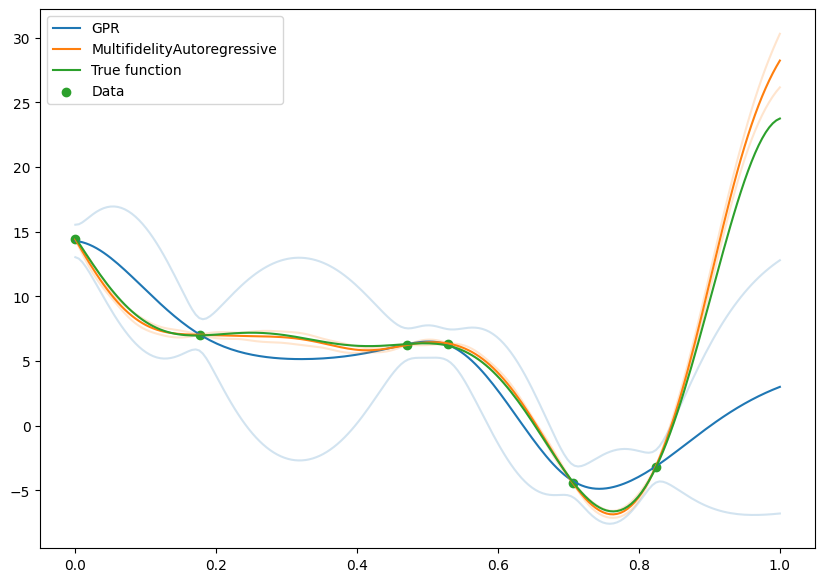

In [9]:
from trieste.models.gpflow import GaussianProcessRegression, build_gpr
from trieste.data import add_fidelity_column

# Get high fidleity data
hf_data = data[2]

# Fit simple gpr model to high fidelity data
gpr_model = GaussianProcessRegression(build_gpr(hf_data, input_search_space))

gpr_model.update(hf_data)
gpr_model.optimize(hf_data)

X = tf.linspace(0, 1, 200)[:, None]
# Turn X into high fidelity query points for the multifidelity model
X_for_multifid = add_fidelity_column(X, 2)

gpr_predictions = gpr_model.predict(X)
multifidelity_predictions = multifidelity_model.predict(X_for_multifid)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

'tab:blue', 'tab:orange', 'tab:green'

# Plot gpr results
mean, var = gpr_predictions
ax.plot(X, mean, label=f"GPR", color='tab:blue')
ax.plot(X, mean + 1.96 * tf.math.sqrt(var), alpha=0.2, color='tab:blue')
ax.plot(X, mean - 1.96 * tf.math.sqrt(var), alpha=0.2, color='tab:blue')

# Plot gpr results
mean, var = multifidelity_predictions
ax.plot(X, mean, label=f"MultifidelityAutoregressive", color='tab:orange')
ax.plot(X, mean + 1.96 * tf.math.sqrt(var), alpha=0.2, color='tab:orange')
ax.plot(X, mean - 1.96 * tf.math.sqrt(var), alpha=0.2, color='tab:orange')


# Plot true function
ax.plot(
    X,
    observer(X_for_multifid, add_noise=False).observations,
    label=f"True function",
    color='tab:green'
)

# Scatter the data
ax.scatter(
        hf_data.query_points,
        hf_data.observations,
        label=f"Data",
        color='tab:green'
    )
plt.legend()
plt.show()


It's clear that there is a large benefit to being able to make use of the low fidelity data.